# Introduction - HMM for *-Seq

In this problem, you will implement the Viterbi algorithm and apply it to a synthetic *-Seq dataset. Import the required packages to get started.

In [ ]:
import numpy as np
from scipy.stats import poisson
import pickle

# 1 - The Viterbi Algorithm

Consider a Hidden Markov Model $(Q, A, 𝛴, E)$, consisting of:
* Set $Q = \{q_1, q_2, ..., q_s\}$ of possible hidden states
* Matrix $A$, where $a_{ij}$ is the transition probability from $q_i$ to $q_j$
* Set $𝛴 = \{σ_1, σ_2, ..., σ_r\}$ of possible observed states
* Matrix $E$, where $e_{ik}$ is probability of emiting symbol $σ_k$ from hidden state $q_i$

Given a sequence of observations $\mathbf{x} = x_1...x_n$, the Viterbi algorithm outputs the most likely sequence of hidden states $\mathbf{\pi^*}=\pi^*_1..\pi^*_n = arg\max_\pi P(x, \pi)$.

In this section, you will implement the Viterbi algorithm. 
Carefully read the function comment and **fill in the TODOs**.

Note that instead of an emission matrix, we use an emission function. That is, the probability of emiting symbol $σ_k$ from hidden state $q_i$ will be the result of evaluating emit_fn($q_i$, $σ_k$) in the function below.

Your implementation should use **not** take products of probabilities but rather use **sums of log probabilities**. 


In [ ]:
'''
Performs Viterbi algorithm and returns a list containing most likely sequence 
of hidden states.

Parameters:
- Q: A list of hidden states, e.g. ['Fair', 'Biased'] for the coin example 
     in lecture
- trans_p: A numpy matrix of transition probabilities
- emit_fn: A function that takes in a hidden state index and observation, and 
           outputs the probability of that emission
- obs: A list of observations

Returns:
- best_path: A list of hidden states, with values from Q
'''
def viterbi(Q, trans_p, emit_fn, obs):
  T = np.zeros((len(Q), len(obs)))
  pointers = np.zeros((len(Q), len(obs)), dtype=int)

  # Initialize T with uniform start state
  for k in range(len(Q)):
    T[k, 0] = np.log((1/len(Q))) + np.log(emit_fn(k, obs[0]))

  # Populate T and pointers
  for t in range(len(obs)):
      for i in range(len(Q)):
          # Compute probability of each state transition
          probs = [T[j, t-1] + np.log(trans_p[i, j]) + np.log(emit_fn(j, obs[t])) for j in range(len(Q))]
          # Get index of most probable transition
          max_idx = np.argmax(probs)
          pointers[i, t] = max_idx
          T[i, t] = probs[max_idx]
          # Add probability of current emission
          # T[i, t] += emit_fn(i, obs[t])

  # Backtrack to find best_path
  best_path = np.zeros(len(obs), dtype=int)
  best_path[-1] = np.argmax(T[:, -1])
  for i in range(len(best_path) - 2, 0, -1):
    best_path[i] = pointers[best_path[i+1], i]

  best_path = [Q[i] for i in best_path]

  return best_path


# 2 - Viterbi on *-Seq Data

Recall that in an HMM for *-Seq data, the observed states are the read counts and the hidden states are whether a genome position is a peak or non-peak. We have created a synthetic dataset of *-Seq data using a mixture of Poission distributions, as discussed in lecture. This data will be used to test your code.

First we import the data. It can be downloaded from `COS343_Spring2023_Public/Homeworks/Datasets/HW5P1_observations.pkl`. Once downloaded, you need to move the two files into your own Google Drive. Then, after executing `drive.mount('/content/drive')`, files in your Google Drive will be present in `/content/drive/MyDrive` and can be accessed by providing the path to them in your Drive.

Modify the path of `data` below to match the path to the data file in your own Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/spring23/HW5P1_observations.pkl", "rb") as f:
  data = pickle.load(f)
obs = data['obs'] # observed read counts
ref_best_path = data['path']

**Plot the distribution of observed read counts.** You may use [plt.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) for this. Do you see a mixture of Poisson distributions? Yes, there is a mixture of 2 Poisson distributions at $\lambda_1 \approx 80, \lambda_2 \approx 120$.

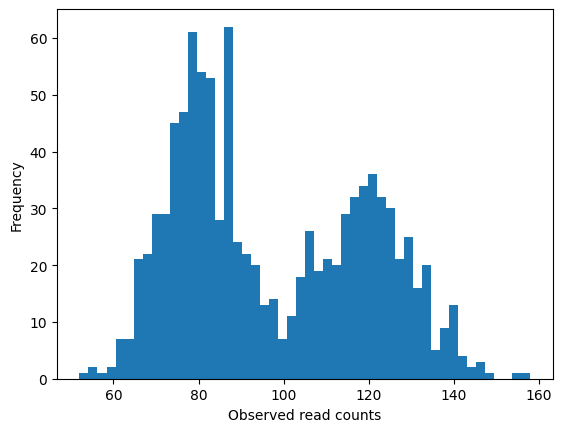

In [ ]:
import matplotlib.pyplot as plt
## TODO ##
plt.hist(obs, bins=50)
plt.xlabel('Observed read counts')
plt.ylabel('Frequency')
plt.show()

Next, run the following two cells to check that the output of your Viterbi implementation is correct.

In [ ]:
# Given a hidden state index and observation, outputs a probability
def peak_emit(hidden, obs):
  if hidden==0:
    return poisson.pmf(obs, 120)
  elif hidden==1:
    return poisson.pmf(obs, 80)
  else:
    raise ValueError("Invalid hidden state")

In [ ]:
Q = ['peak', 'nonpeak']
trans_p = np.array([[0.7, 0.3], [0.2, 0.8]])
best_path = viterbi(Q, trans_p, peak_emit, obs)
assert best_path == ref_best_path

# (BONUS: 10pts) 3 - The Forward-Backward Algorithm

Given a sequence of observations $\mathbf{x} = x_1...x_n$, the forward-backward algorithm outputs the marginal probabilities $P(\pi_i=q|\mathbf{x})$ that hidden state was $q$ at each timestep $i$.

In this section, you will implement the forward-backward algorithm. Carefully read the function comment and fill in the TODOs. You may come up with your own simple test case or use one from lecture.

In [ ]:
'''
Performs forward-backward algorithm and returns posterior probabiltities

Parameters:
- Q: A list of hidden states, e.g. ['Fair', 'Biased'] for the coin example 
     in lecture
- trans_p: A numpy matrix of transition probabilities
- emit_p: A numpy matrix of emission probabilities
- obs: A list of observations, converted to integer indices. For example, if the
       possible observed states are ["Heads", "Tails"] and the observations are
       ["Tails", "Tails", "Heads"], obs is passed in as [1, 1, 0]

Returns:
- posterior: a |Q|x|obs| matrix of marginal probabilities
'''
def forward_backward(Q, trans_p, emit_p, obs):
  T_fwd = np.zeros((len(Q), len(obs)))
  T_bwd = np.zeros((len(Q), len(obs)))

  ## TODO ##

  # Step 1: Calculate the forward probabilities
  T_fwd[:, 0] = emit_p[:, obs[0]] / len(Q)
  for i in range(1, len(obs)):
      for j in range(len(Q)):
          T_fwd[j, i] = emit_p[j, obs[i]] * np.sum(T_fwd[:, i-1] * trans_p[:, j])
      T_fwd[:, i] /= np.sum(T_fwd[:, i])

  # Step 2: Calculate the backward probabilities
  T_bwd[:, -1] = 1
  for i in range(len(obs)-2, -1, -1):
      for j in range(len(Q)):
          T_bwd[j, i] = np.sum(emit_p[:, obs[i+1]] * T_bwd[:, i+1] * trans_p[j, :])
      T_bwd[:, i] /= np.sum(T_bwd[:, i])

  # Step 3: Combine forward and backward probabilities to obtain the posterior probabilities
  posterior = T_fwd * T_bwd
  posterior /= np.sum(posterior, axis=0)

  return posterior



In [ ]:
Q = ['F', 'B']
trans_p = np.array([[0.9, 0.1], [0.1, 0.9]])
emit_p = np.array([[0.5, 0.5], [0.25, 0.75]])
sigma = {'T': 0, 'H': 1}

x = ['T', 'H', 'T', 'H', 'H', 'H', 'T', 'H', 'T', 'T', 'H']
x = [sigma[xi] for xi in x]

posterior = forward_backward(Q, trans_p, emit_p, x)

true_posterior = np.array([[0.63574262, 0.59293879, 0.6004579, 0.53251141, 0.51509767, 0.54440741, 0.62685215, 0.633197, 0.69236854, 0.68567714, 0.6094007], 
                           [0.36425738, 0.40706121, 0.3995421, 0.46748859, 0.48490233, 0.45559259, 0.37314785, 0.366803, 0.30763146, 0.31432286, 0.3905993]])
assert np.allclose(posterior, true_posterior)